In [1]:
import os
import dmd
os.environ["OMP_NUM_THREADS"]='4'
import matplotlib.pyplot as plt
import numpy as np
import timeit
from scipy.linalg import pinv, svd, eig, svdvals
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar

In [2]:
# N=10000
# K=2
# seed=1
# c=1
# t1=100
# dt=1E-2
# atol=1E-10
# fs=np.zeros(N+2)
# ns=[0,1,-1]
# omega=np.zeros(N)

# filebase='data/dmd1'
# os.system('mkdir -p %s'%(filebase))
# for n in np.arange(len(ns)):
#     os.system('rm %s/%i*'%(filebase,n))
#     fs[np.argsort(-omega)]=ns[n]*(2*np.pi*np.arange(N)/N-np.pi)
#     fs[-2]=-1E-14
#     fs[-1]=0.01
#     fs.tofile('%s/%ifs.dat'%(filebase,n))
#     os.system('bash -c "./kuramoto_64 -N %i -K %i -c %f -t %f -d %f -s %i -a %e -g 3 -nvR %s/%i"'%(N,K,c,t1,dt,seed,atol,filebase,n))
#     omega=np.fromfile('%s/0frequencies.dat'%(filebase),dtype=np.float64)

# K=2
# c=1.75
# filebase='data/dmd2'
# os.system('mkdir -p %s'%(filebase))
# for n in np.arange(len(ns)):
#     os.system('rm %s/%i*'%(filebase,n))
#     fs[np.argsort(-omega)]=ns[n]*(2*np.pi*np.arange(N)/N-np.pi)
#     fs[-2]=-1E-14
#     fs[-1]=0.01
#     fs.tofile('%s/%ifs.dat'%(filebase,n))
#     os.system('bash -c "./kuramoto_64 -N %i -K %i -c %f -t %f -d %f -s %i -a %e -g 3 -nvR %s/%i"'%(N,K,c,t1,dt,seed,atol,filebase,n))
#     omega=np.fromfile('%s/0frequencies.dat'%(filebase),dtype=np.float64)

# K=N
# c=1.75
# filebase='data/dmd3'
# os.system('mkdir -p %s'%(filebase))
# for n in np.arange(len(ns)):
#     os.system('rm %s/%i*'%(filebase,n))
#     fs[np.argsort(-omega)]=ns[n]*(2*np.pi*np.arange(N)/N-np.pi)
#     fs[-2]=-1E-14
#     fs[-1]=0.01
#     fs.tofile('%s/%ifs.dat'%(filebase,n))
#     os.system('bash -c "./kuramoto_64 -N %i -K %i -c %f -t %f -d %f -s %i -a %e -g 3 -nvR %s/%i"'%(N,K,c,t1,dt,seed,atol,filebase,n))
#     omega=np.fromfile('%s/0frequencies.dat'%(filebase),dtype=np.float64)

In [3]:
# for i in [1,2,3]:
#     # os.system('rm data/dmd%i/u.dat'%(i))
#     # os.system('rm data/dmd%i/s.dat'%(i))
#     # os.system('rm data/dmd%i/v.dat'%(i))
#     # os.system('rm data/dmd%i/errs.dat'%(i))
#     # os.system('rm data/dmd%i/evals.dat'%(i))
#     # os.system('rm data/dmd%i/evecs.dat'%(i))
#     # os.system('rm data/dmd%i/res.dat'%(i))
#     os.system('rm data/dmd%i/zs.dat'%(i))
#     os.system('rm data/dmd%i/pseudo.dat'%(i))
#     os.system('rm data/dmd%i/xis.dat'%(i))

In [4]:
# os.system('./dmd.py --pcatol 1E-10 --filebase data/dmd1/')
# os.system('./dmd.py --pcatol 1E-10 --filebase data/dmd2/')
# os.system('./dmd.py --pcatol 1E-10 --filebase data/dmd3/')

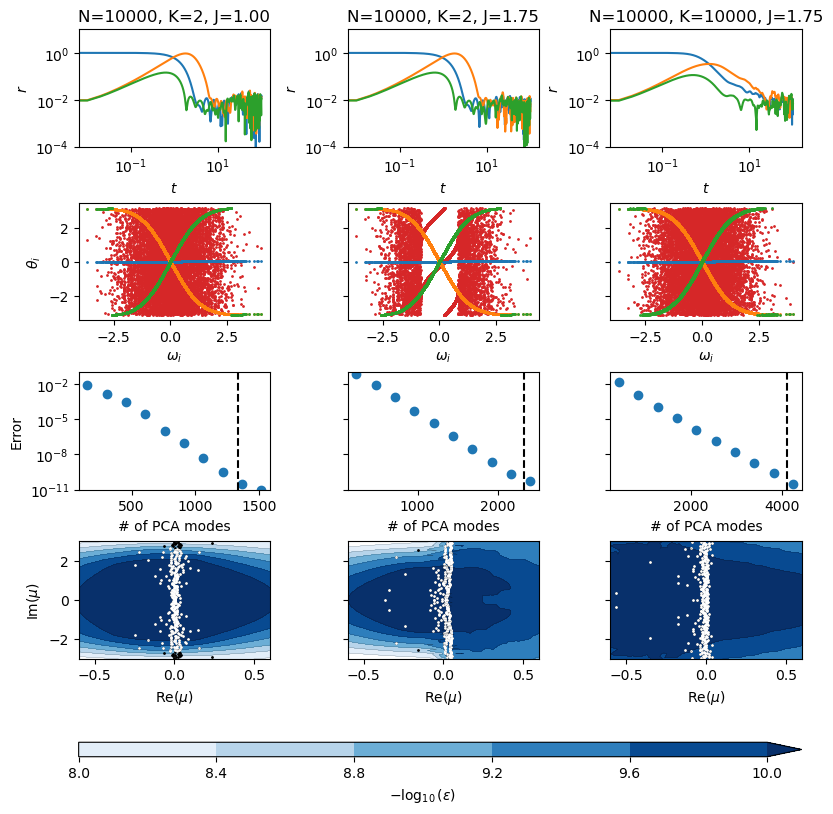

In [5]:
filebases=['data/dmd1','data/dmd2','data/dmd3']
fig,axs=plt.subplots(4,3,figsize=(8,8) ,constrained_layout=True)

m=0
for filebase0 in filebases:
    for n in range(3):
        filebase='%s/%i'%(filebase0,n)
        file=open(filebase+'.out')
        lines=file.readlines()
        N,K,t1,dt,c,seed=np.array(lines[0].split(),dtype=np.float64)
        N=int(N)
        K=int(K)
        file.close()
    
        omega=np.fromfile(filebase+'frequencies.dat',dtype=np.float64)
        N=len(omega)
        thetas=np.fromfile(filebase+'thetas.dat',dtype=np.float64).reshape((-1,N))
        thetas=thetas-np.mean(omega)*dt*np.arange(thetas.shape[0])[:,np.newaxis]
        orders=np.fromfile(filebase+'order.dat',dtype=np.float64)
    
        plt.subplot(4,3,1+m)
        plt.plot(dt*np.arange(orders.shape[0]),orders)
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('$t$')
        plt.ylabel('$r$')
        plt.ylim(1E-4,1E1)
        plt.title('N=%i, K=%i, J=%.2f'%(N, K,c))
        plt.subplot(4,3,4+m)
        plt.scatter(omega,np.mod(thetas[0]+np.pi,2*np.pi)-np.pi,s=1,zorder=5)
        plt.xlabel('$\omega_i$')
        if m>0:
            plt.gca().set_yticklabels([])
        else:
            plt.ylabel(r'$\theta_i$')
        
    plt.scatter(omega,np.mod(thetas[-1]+np.pi,2*np.pi)-np.pi,s=1,zorder=3)
    
    plt.subplot(4,3,7+m)
    plt.scatter(*np.fromfile('%s/errs.dat'%(filebase0)).reshape((2,-1)))
    plt.yscale('log')
    plt.xlabel('# of PCA modes')
    if m>0:
        plt.gca().set_yticklabels([])
    else:
        plt.ylabel('Error')
    r=np.fromfile('%s/evals.dat'%(filebase0),dtype=np.complex128).shape
    plt.ylim(1E-11,1E-1)
    
    plt.plot([r,r],[1E-11,1E-1],c='black',ls='--')
    
    vals1=np.fromfile('%s/pseudo.dat'%(filebase0))
    zs1=np.fromfile('%s/zs.dat'%(filebase0),dtype=np.complex128)
    nr=26
    ni=26
    
    resmin=1E-8
    resmax=1E-10
    rescrit=1E-9
    levels=-np.log(resmin)/np.log(10)+(-np.log(resmax)/np.log(10)+np.log(resmin)/np.log(10))*np.arange(6)/5
    
    plt.subplot(4,3,10+m)
    cs1 = plt.gca().tricontourf(np.real(np.log(zs1)/dt),np.imag(np.log(zs1)/dt),np.log(1/np.array(vals1))/np.log(10),levels=levels,cmap='Blues',extend='max')
    cs2 = plt.gca().tricontour(cs1,levels=levels,colors=('k',),linewidths=0.1)
    
    xs1=np.real(np.log(zs1[:-nr*ni])/dt)
    ys1=np.imag(np.log(zs1[:-nr*ni])/dt)
    inds=np.where(vals1[:-nr*ni]<rescrit)[0]
    plt.scatter(xs1,ys1,c='black',s=1)
    plt.scatter(xs1[inds],ys1[inds],c='white',s=1)
    plt.ylim(-3,3)
    plt.xlim(-0.6,0.6)
    if m>0:
        plt.gca().set_yticklabels([])
    else:
        plt.ylabel('$\mathrm{Im}({\mu})$')
    plt.xlabel('$\mathrm{Re}({\mu})$')
    m=m+1

fig.colorbar(cs1, ax=axs[:4,:3], location='bottom',aspect=50,label=r'$-\log_{10}(\varepsilon)$')

plt.savefig('dmd.pdf')
plt.show()

In [6]:
evals

NameError: name 'evals' is not defined

In [7]:
filebase0='data/dmd2/'
thetas=[]
n=0
while os.path.exists('%s%i.out'%(filebase0,n)):
    filebase='%s%i'%(filebase0,n)
    file=open(filebase+'.out')
    lines=file.readlines()
    N,K,t1,dt,c,seed=np.array(lines[0].split(),dtype=np.float64)
    N=int(N)
    K=int(K)
    print(lines[1])
    print(lines[-1])
    file.close()

    omega=np.fromfile(filebase+'frequencies.dat',dtype=np.float64)
    N=len(omega)
    theta=np.fromfile(filebase+'thetas.dat',dtype=np.float64).reshape((-1,N))
    theta=theta-np.mean(omega)*dt*np.arange(theta.shape[0])[:,np.newaxis]
    thetas=thetas+[theta]
    n=n+1

X=np.concatenate([theta[:-1] for theta in thetas],axis=0)
X=np.concatenate([np.sin(X), np.cos(X), np.ones((X.shape[0],1))],axis=1)
Y=np.concatenate([theta[1:] for theta in thetas],axis=0)
Y=np.concatenate([np.sin(Y), np.cos(Y), np.ones((Y.shape[0],1))],axis=1)

s=np.fromfile('%ss.dat'%(filebase0),dtype=np.float64)
rank=len(s)
u=np.fromfile('%su.dat'%(filebase0),dtype=np.float64).reshape((-1,rank))
v=np.fromfile('%sv.dat'%(filebase0),dtype=np.float64).reshape((rank,-1))
evals=np.fromfile('%sevals.dat'%(filebase0),dtype=np.complex128)
r=len(evals)
evecs=np.fromfile('%sevecs.dat'%(filebase0),dtype=np.complex128).reshape((-1,r))
res=np.fromfile('%sres.dat'%(filebase0),dtype=np.complex128)
vals=np.fromfile('%spseudo.dat'%(filebase0),dtype=np.float64)
xis=np.fromfile('%sxis.dat'%(filebase0),dtype=np.complex128).reshape((-1,r)).T
zs=np.fromfile('%szs.dat'%(filebase0),dtype=np.complex128)

./kuramoto_64 -N 10000 -K 2 -c 1.750000 -t 100.000000 -d 0.010000 -s 1 -a 1.000000e-10 -g 3 -nvR data/dmd2/0 

runtime: 77.332191

./kuramoto_64 -N 10000 -K 2 -c 1.750000 -t 100.000000 -d 0.010000 -s 1 -a 1.000000e-10 -g 3 -nvR data/dmd2/1 

runtime: 77.426871

./kuramoto_64 -N 10000 -K 2 -c 1.750000 -t 100.000000 -d 0.010000 -s 1 -a 1.000000e-10 -g 3 -nvR data/dmd2/2 

runtime: 77.508299



In [8]:
evals

array([0.32098083+0.01545655j, 0.32098083-0.01545655j,
       0.33978523+0.01995073j, ..., 0.99999929-0.00758966j,
       1.0002225 +0.00425752j, 1.0002225 -0.00425752j])

In [7]:
U=u[:,:r]
V=v[:r,:]
S=s[:r]
# A=Y.dot(np.conjugate(V).T*1/S)
# B=X.dot(np.conjugate(V).T*1/S)
# L=np.conjugate(A).T.dot(A)
# G=np.conjugate(A).T.dot(B)
# E=np.conjugate(B).T.dot(B)

215 (0.9994693370514813+0.004024238678308698j) 8.751914924906787e-12


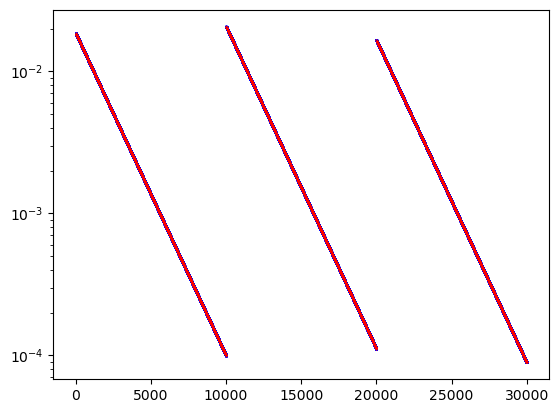

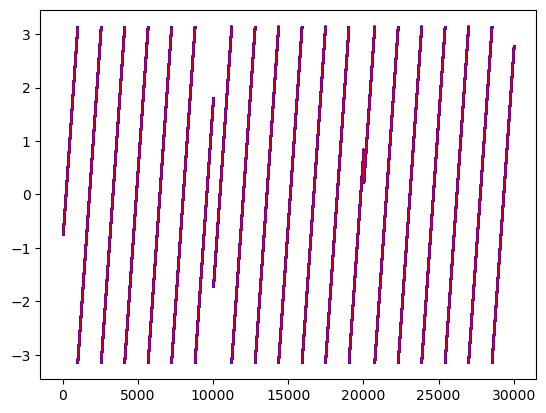

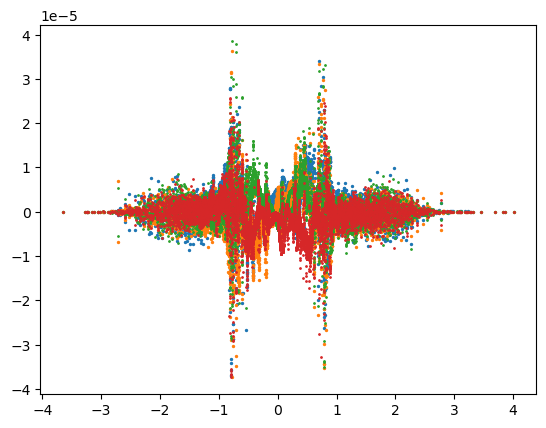

In [8]:
vs=(np.conjugate(V).T*1/S).dot(xis)
i=np.argmin(vals[:-26*26])
print(i,zs[i],vals[i])
plt.plot(np.abs(Y.dot(vs[:,i])),'bo',ms=1)
plt.plot(np.abs(zs[i]*X.dot(vs[:,i])),'ro',ms=0.1)
plt.yscale('log')
plt.show()
plt.plot((np.angle(Y.dot(vs[:,i]))),'bo',ms=1)
plt.plot((np.angle(zs[i]*X.dot(vs[:,i]))),'ro',ms=0.1)
plt.show()

plt.scatter(omega,np.real(vs[:N,i]),s=2)
plt.scatter(omega,np.imag(vs[:N,i]),s=2)
plt.scatter(omega,np.real(vs[N:-1,i]),s=1)
plt.scatter(omega,np.imag(vs[N:-1,i]),s=1)
plt.show()

In [9]:
# N=10000
# seed=1
# t1=100
# dt=1E-2
# atol=1E-10
# fs=np.zeros(N+2)
# ns=[2,-2,0]
# omega=np.zeros(N)

# K=2
# c=1
# filebase='data/dmd1/test'
# os.system('mkdir -p %s'%(filebase))
# for n in np.arange(len(ns)):
#     os.system('rm %s%i*'%(filebase,n))
#     fs[np.argsort(-omega)]=ns[n]*(2*np.pi*np.arange(N)/N-np.pi)
#     fs[-2]=-1E-14
#     fs[-1]=0.01
#     fs.tofile('%s/test_%ifs.dat'%(filebase,n))
#     os.system('bash -c "./kuramoto_64 -N %i -K %i -c %f -t %f -d %f -s %i -a %e -g 3 -nvR %s/%i"'%(N,K,c,t1,dt,seed,atol,filebase,n))

# K=2
# c=1.75
# filebase='data/dmd2/test'
# os.system('mkdir -p %s'%(filebase))
# for n in np.arange(len(ns)):
#     os.system('rm %s/%i*'%(filebase,n))
#     fs[np.argsort(-omega)]=ns[n]*(2*np.pi*np.arange(N)/N-np.pi)
#     fs[-2]=-1E-14
#     fs[-1]=0.01
#     fs.tofile('%s/%ifs.dat'%(filebase,n))
#     os.system('bash -c "./kuramoto_64 -N %i -K %i -c %f -t %f -d %f -s %i -a %e -g 3 -nvR %s/%i"'%(N,K,c,t1,dt,seed,atol,filebase,n))

# K=N
# c=1.75
# filebase='data/dmd3/test'
# os.system('mkdir -p %s'%(filebase))
# for n in np.arange(len(ns)):
#     os.system('rm %s/%i*'%(filebase,n))
#     fs[np.argsort(-omega)]=ns[n]*(2*np.pi*np.arange(N)/N-np.pi)
#     fs[-2]=-1E-14
#     fs[-1]=0.01
#     fs.tofile('%s/%ifs.dat'%(filebase,n))
#     os.system('bash -c "./kuramoto_64 -N %i -K %i -c %f -t %f -d %f -s %i -a %e -g 3 -nvR %s/%i"'%(N,K,c,t1,dt,seed,atol,filebase,n))
#     omega=np.fromfile('%s/0frequencies.dat'%(filebase),dtype=np.float64)

In [10]:
filebase0='data/dmd2/test/'
thetas_test=[]
n=0
while os.path.exists('%s%i.out'%(filebase0,n)):
    filebase='%s%i'%(filebase0,n)
    file=open(filebase+'.out')
    lines=file.readlines()
    N,K,t1,dt,c,seed=np.array(lines[0].split(),dtype=np.float64)
    N=int(N)
    K=int(K)
    print(lines[1])
    print(lines[-1])
    file.close()

    omega=np.fromfile(filebase+'frequencies.dat',dtype=np.float64)
    N=len(omega)
    theta=np.fromfile(filebase+'thetas.dat',dtype=np.float64).reshape((-1,N))
    theta=theta-np.mean(omega)*dt*np.arange(theta.shape[0])[:,np.newaxis]
    thetas_test=thetas_test+[theta]
    n=n+1

X_test=np.concatenate([theta[:-1] for theta in thetas_test],axis=0)
X_test=np.concatenate([np.sin(X_test), np.cos(X_test), np.ones((X_test.shape[0],1))],axis=1)
Y_test=np.concatenate([theta[1:] for theta in thetas_test],axis=0)
Y_test=np.concatenate([np.sin(Y_test), np.cos(Y_test), np.ones((Y_test.shape[0],1))],axis=1)

./kuramoto_64 -N 10000 -K 2 -c 1.750000 -t 100.000000 -d 0.010000 -s 1 -a 1.000000e-10 -g 3 -nvR data/dmd2/test/0 

runtime: 82.498322

./kuramoto_64 -N 10000 -K 2 -c 1.750000 -t 100.000000 -d 0.010000 -s 1 -a 1.000000e-10 -g 3 -nvR data/dmd2/test/1 

runtime: 79.664576

./kuramoto_64 -N 10000 -K 2 -c 1.750000 -t 100.000000 -d 0.010000 -s 1 -a 1.000000e-10 -g 3 -nvR data/dmd2/test/2 

runtime: 79.277018



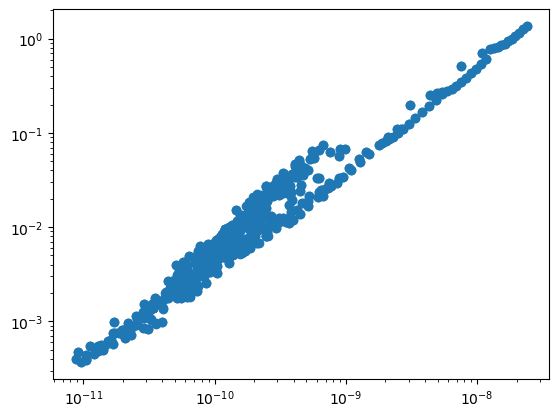

In [11]:
vals2=np.linalg.norm(Y_test.dot(vs)-zs[np.newaxis,:]*X_test.dot(vs),axis=0)/np.linalg.norm(X.dot(vs),axis=0)
plt.scatter(vals,vals2)
plt.yscale('log')
plt.xscale('log')

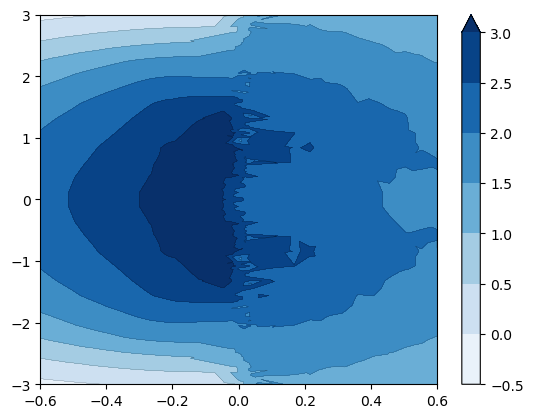

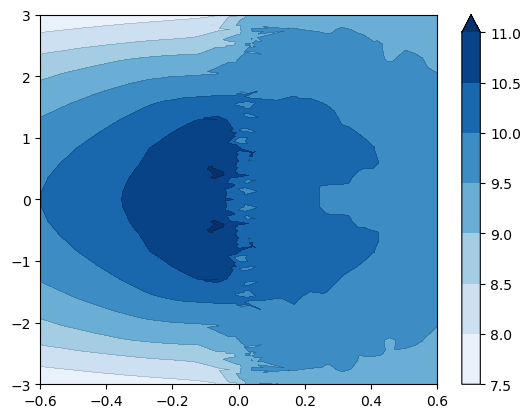

In [12]:
cs1 = plt.gca().tricontourf(np.real(np.log(zs)/dt),np.imag(np.log(zs)/dt),np.log(1/np.array(vals2))/np.log(10),cmap='Blues',extend='max')
cs2 = plt.gca().tricontour(cs1,colors=('k',),linewidths=0.1)
fig.colorbar(cs1)
plt.show()
cs1 = plt.gca().tricontourf(np.real(np.log(zs)/dt),np.imag(np.log(zs)/dt),np.log(1/np.array(vals))/np.log(10),cmap='Blues',extend='max')
cs2 = plt.gca().tricontour(cs1,colors=('k',),linewidths=0.1)
fig.colorbar(cs1)
plt.show()

215 (0.9994693370514813+0.004024238678308698j) 8.751914924906787e-12


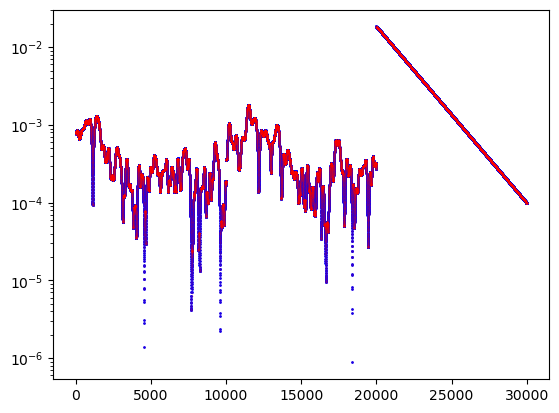

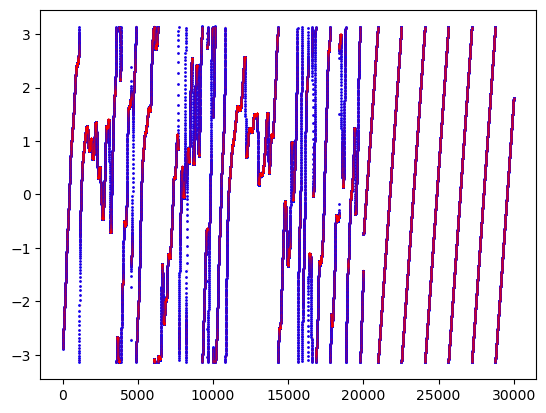

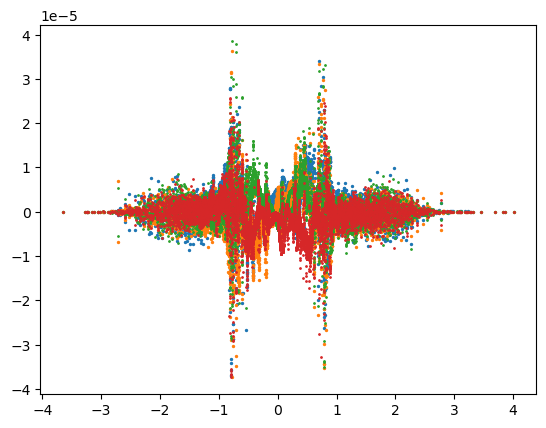

In [13]:
vs=(np.conjugate(V).T*1/S).dot(xis)
i=np.argmin(vals[:-26*26])
print(i,zs[i],vals[i])
plt.plot(np.abs(Y_test.dot(vs[:,i])),'bo',ms=1)
plt.plot(np.abs(zs[i]*X_test.dot(vs[:,i])),'ro',ms=0.1)
plt.yscale('log')
plt.show()
plt.plot((np.angle(Y_test.dot(vs[:,i]))),'bo',ms=1)
plt.plot((np.angle(zs[i]*X_test.dot(vs[:,i]))),'ro',ms=0.1)
plt.show()

plt.scatter(omega,np.real(vs[:N,i]),s=2)
plt.scatter(omega,np.imag(vs[:N,i]),s=2)
plt.scatter(omega,np.real(vs[N:-1,i]),s=1)
plt.scatter(omega,np.imag(vs[N:-1,i]),s=1)
plt.show()

In [14]:
vals3=dmd.resDMDpseudo(U,V,S,X_test,Y_test,zs,zs,xis,filebase0,True)

0.998972
pseudospectra runtime: 11515.301513620652


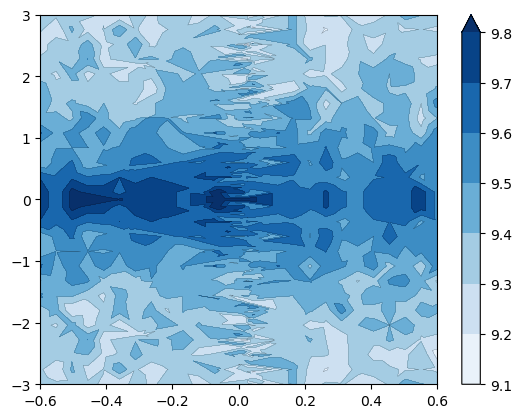

In [19]:
cs1 = plt.gca().tricontourf(np.real(np.log(zs)/dt),np.imag(np.log(zs)/dt),np.log(1/np.array(vals3))/np.log(10),cmap='Blues',extend='max')
cs2 = plt.gca().tricontour(cs1,colors=('k',),linewidths=0.1)
fig.colorbar(cs1)
